In [1]:
from sklearn import svm , tree,linear_model ,neighbors,naive_bayes , ensemble , discriminant_analysis , gaussian_process
from xgboost import XGBClassifier

from sklearn.preprocessing import OneHotEncoder , LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

%matplotlib inline

mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

In [2]:
import pandas as pd

In [3]:
data_raw = pd.read_csv('train.csv')

In [7]:
data_val = pd.read_csv('test.csv')

In [8]:
data1 = data_raw.copy()

In [9]:
data_cleaner = [data1 , data_val] #训练数据 测试数据合在一起

In [12]:
data_raw.sample(4) #随机采样4个

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
46,47,0,3,"Lennon, Mr. Denis",male,NaN,1,0,370371,15.5000,NaN,Q
547,548,1,2,"Padro y Manent, Mr. Julian",male,NaN,0,0,SC/PARIS 2146,13.8625,NaN,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
226,227,1,2,"Mellors, Mr. William John",male,19.0,0,0,SW/PP 751,10.5000,NaN,S


In [13]:
data_raw.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Garside, Miss. Ethel",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [15]:
#缺失值的填充
for dataset in data_cleaner:
    dataset['Age'].fillna(dataset['Age'].median() , inplace = True)
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0] , inplace=True)
    dataset['Fare'].fillna(dataset['Fare'].median() , inplace=True)

drop_column = ['PassengerId' , 'Cabin' , 'Ticket']

data1.drop(drop_column , axis = 1 , inplace=True)

In [14]:
data_raw.Sex.mode()

0    male
dtype: object

In [16]:
for dataset in data_cleaner:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
    dataset['IsAlone'] = 1
    dataset['IsAlone'].loc[dataset['FamilySize'] >1 ] = 0
    
    dataset['Title'] = dataset['Name'].str.split(', ' , expand=True)[1].str.split('.' , expand=True)[0]
    
    dataset['FareBin'] = pd.qcut(dataset['Fare'] , 4)
    
    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int) , 5)


stat_min = 10
title_names = (data1['Title'].value_counts() < stat_min)

data1['Title'] = data1['Title'].apply(lambda x: 'Misc' if title_names.loc[x] ==True else x)


I:\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [17]:
data1['Title'].value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
Misc       27
Name: Title, dtype: int64

In [21]:
label = LabelEncoder()
for dataset in data_cleaner:
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])    
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])    
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])    
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin']) 

Target = ['Survived']

data1_x = ['Sex','Pclass', 'Embarked', 'Title','SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone']
data1_x_calc = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code','SibSp', 'Parch', 'Age', 'Fare']
data1_xy = Target + data1_x

data1_x_bin = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code']
data1_xy_bin = Target + data1_x_bin

data1_dummy = pd.get_dummies(data1[data1_x])
data1_x_dummy = data1_dummy.columns.tolist()
data1_xy_dummy = Target + data1_x_dummy

data1_dummy

,Pclass,SibSp,Parch,Age,Fare,FamilySize,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs
0,3,1,0,22.0,7.2500,2,0,0,1,0,0,1,0,0,0,1,0
1,1,1,0,38.0,71.2833,2,0,1,0,1,0,0,0,0,0,0,1
2,3,0,0,26.0,7.9250,1,1,1,0,0,0,1,0,0,1,0,0
3,1,1,0,35.0,53.1000,2,0,1,0,0,0,1,0,0,0,0,1
4,3,0,0,35.0,8.0500,1,1,0,1,0,0,1,0,0,0,1,0
5,3,0,0,28.0,8.4583,1,1,0,1,0,1,0,0,0,0,1,0
6,1,0,0,54.0,51.8625,1,1,0,1,0,0,1,0,0,0,1,0
7,3,3,1,2.0,21.0750,5,0,0,1,0,0,1,1,0,0,0,0
8,3,0,2,27.0,11.1333,3,0,1,0,0,0,1,0,0,0,0,1
9,2,1,0,14.0,30.0708,2,0,1,0,1,0,0,0,0,0,0,1


In [20]:
data_cleaner[0].head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,FareBin,AgeBin
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,2,0,Mr,"(-0.001, 7.91]","(16.0, 32.0]"
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,2,0,Mrs,"(31.0, 512.329]","(32.0, 48.0]"
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,1,1,Miss,"(7.91, 14.454]","(16.0, 32.0]"
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,2,0,Mrs,"(31.0, 512.329]","(32.0, 48.0]"
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1,1,Mr,"(7.91, 14.454]","(32.0, 48.0]"


['Sex_Code',
 'Pclass',
 'Embarked_Code',
 'Title_Code',
 'SibSp',
 'Parch',
 'Age',
 'Fare']

In [25]:
train1_x, test1_x, train1_y, test1_y = model_selection.train_test_split(data1[data1_x_calc], data1[Target], random_state = 0)
train1_x_bin, test1_x_bin, train1_y_bin, test1_y_bin = model_selection.train_test_split(data1[data1_x_bin], data1[Target] , random_state = 0)
train1_x_dummy, test1_x_dummy, train1_y_dummy, test1_y_dummy = model_selection.train_test_split(data1_dummy[data1_x_dummy], data1[Target], random_state = 0)

In [27]:
data1_x

['Sex',
 'Pclass',
 'Embarked',
 'Title',
 'SibSp',
 'Parch',
 'Age',
 'Fare',
 'FamilySize',
 'IsAlone']

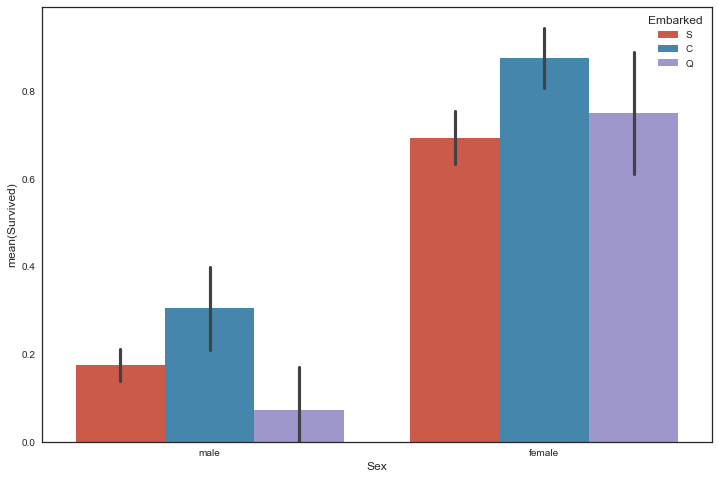

In [35]:
#fig, qaxis = plt.subplots(figsize=(14,12))
#sns.barplot(x = 'Sex', y = 'Survived', hue = 'Embarked', data=data1)
sns.barplot(x = data1['Sex'], y = data1['Survived'], hue = data1['Embarked'])#, data=data1)

In [37]:
MLA = [
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),
    
    gaussian_process.GaussianProcessClassifier(),
    
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(), #感知机
    
    
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    neighbors.KNeighborsClassifier(),
    
    svm.SVC(probability=True),
    svm.NuSVC(probability = True),
    svm.LinearSVC(),
    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),
    
    XGBClassifier()
]

In [47]:
for index , row in data1.iterrows():
    print(index , row)

0 Survived                               0
Pclass                                 3
Name             Braund, Mr. Owen Harris
Sex                                 male
Age                                   22
SibSp                                  1
Parch                                  0
Fare                                7.25
Embarked                               S
FamilySize                             2
IsAlone                                0
Title                                 Mr
FareBin                   (-0.001, 7.91]
AgeBin                      (16.0, 32.0]
Sex_Code                               1
Embarked_Code                          2
Title_Code                             3
AgeBin_Code                            1
FareBin_Code                           0
Name: 0, dtype: object
1 Survived                                                         1
Pclass                                                           1
Name             Cumings, Mrs. John Bradley (Florence Briggs

68 Survived                                       1
Pclass                                         3
Name             Andersson, Miss. Erna Alexandra
Sex                                       female
Age                                           17
SibSp                                          4
Parch                                          2
Fare                                       7.925
Embarked                                       S
FamilySize                                     7
IsAlone                                        0
Title                                       Miss
FareBin                           (7.91, 14.454]
AgeBin                              (16.0, 32.0]
Sex_Code                                       0
Embarked_Code                                  2
Title_Code                                     2
AgeBin_Code                                    1
FareBin_Code                                   1
Name: 68, dtype: object
69 Survived                         0
Pcla

171 Survived                            0
Pclass                              3
Name             Rice, Master. Arthur
Sex                              male
Age                                 4
SibSp                               4
Parch                               1
Fare                           29.125
Embarked                            Q
FamilySize                          6
IsAlone                             0
Title                          Master
FareBin                (14.454, 31.0]
AgeBin                  (-0.08, 16.0]
Sex_Code                            1
Embarked_Code                       1
Title_Code                          0
AgeBin_Code                         0
FareBin_Code                        2
Name: 171, dtype: object
172 Survived                                    1
Pclass                                      3
Name             Johnson, Miss. Eleanor Ileen
Sex                                    female
Age                                         1
SibSp          

324 Survived                                0
Pclass                                  3
Name             Sage, Mr. George John Jr
Sex                                  male
Age                                    28
SibSp                                   8
Parch                                   2
Fare                                69.55
Embarked                                S
FamilySize                             11
IsAlone                                 0
Title                                  Mr
FareBin                   (31.0, 512.329]
AgeBin                       (16.0, 32.0]
Sex_Code                                1
Embarked_Code                           2
Title_Code                              3
AgeBin_Code                             1
FareBin_Code                            3
Name: 324, dtype: object
325 Survived                                1
Pclass                                  1
Name             Young, Miss. Marie Grice
Sex                                female
A

In [49]:
import random

In [52]:
for index , row in data1.iterrows():
    if random.random()>0.5:
        data1.set_value(index , 'Random_Predict' , 1)
    else:
        data1.set_value(index , 'Random_Predict' , 0)
    
data1['Random_Score'] = 0
data1.loc[(data1.Survived == data1['Random_Predict']), 'Random_Score'] = 1
print('random guess %.2f' % (data1['Random_Score'].mean()))

random guess 0.47


In [53]:
metrics.accuracy_score(data1.Survived , data1.Random_Predict)

0.4702581369248036

In [56]:
pivot_female = data1[data1.Sex == 'female'].groupby(['Sex','Pclass', 'Embarked','FareBin'])['Survived'].mean()
pivot_female

Sex     Pclass  Embarked  FareBin        
female  1       C         (14.454, 31.0]     0.666667
                          (31.0, 512.329]    1.000000
                Q         (31.0, 512.329]    1.000000
                S         (14.454, 31.0]     1.000000
                          (31.0, 512.329]    0.955556
        2       C         (7.91, 14.454]     1.000000
                          (14.454, 31.0]     1.000000
                          (31.0, 512.329]    1.000000
                Q         (7.91, 14.454]     1.000000
                S         (7.91, 14.454]     0.875000
                          (14.454, 31.0]     0.916667
                          (31.0, 512.329]    1.000000
        3       C         (-0.001, 7.91]     1.000000
                          (7.91, 14.454]     0.428571
                          (14.454, 31.0]     0.666667
                Q         (-0.001, 7.91]     0.750000
                          (7.91, 14.454]     0.500000
                          (14.454, 31.0]

In [57]:
pivot_male = data1[data1.Sex == 'male'].groupby(['Sex','Title'])['Survived'].mean()
pivot_male

Sex   Title 
male  Master    0.575000
      Misc      0.250000
      Mr        0.156673
Name: Survived, dtype: float64

In [62]:
def mytree(df):
    Model = pd.DataFrame(data = {'Predict':[]})
    male_title = ['Master']
    
    for index , row in df.iterrows():
        Model.loc[index , 'Predict'] = 0
        
        if df.loc[index , 'Sex'] == 'female':
            Model.loc[index , 'Predict'] = 1
        
        if ((df.loc[index , 'Sex'] == 'female')&
        (df.loc[index , 'Pclass'] == 3) &
        (df.loc[index , 'Embarked'] == 'S') &
        (df.loc[index , 'Fare'] > 8)):
            Model.loc[index , 'Predict'] = 0
        
        if ((df.loc[index , 'Sex'] == 'male') &
        (df.loc[index , 'Title'] in male_title)):
            Model.loc[index , 'Predict'] = 1
            
    return Model

In [64]:
Tree_Predict = mytree(data1)
metrics.accuracy_score(data1['Survived'] , Tree_Predict)

0.8204264870931538

In [66]:
print(metrics.classification_report(data1.Survived , Tree_Predict))

             precision    recall  f1-score   support

          0       0.82      0.91      0.86       549
          1       0.82      0.68      0.75       342

avg / total       0.82      0.82      0.82       891



In [ ]:
import itertools
import numpy as np

def plot_confusion_matrix(cm , classes , normalize = False,
                         title='Confusion matrix',
                         cmap = plt.cm.Blues):
    if normalize:
        cm = cm.astype('float')/cm.sum(axis = 1)[: , np.newaxis]
        print('have normalize')
    else:
        print('no normalize')
    
    print(cm)
    
# in 26    